In [1]:
import pandas as pd 

filename = "imdb_master.csv"
review = pd.read_csv(filename,sep=",",encoding="iso-8859-1")

review.drop(review.columns.values[0],axis=1,inplace=True)
review.head()

,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [2]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

cinema_words = ["cinema","movie","film","action","screen",\
"cast","camera","blockbuster","studio","motion","camera",\
"actor","theater","one","character","story","time","even","really"]

stopwords = set(stopwords.words("english")+cinema_words)
lem = WordNetLemmatizer()

def make_corpus(text):
    text = BeautifulSoup(text,"html.parser").get_text()
    text = re.sub("\[[^]]*\]"," ",text)
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    text = text.lower().split()
    text = [w for w in text if not w in stopwords]
    text = [lem.lemmatize(w) for w in text]
    return " ".join(text)

In [3]:
ind = review[review["label"]=="unsup"].index.values
review.drop(ind,inplace=True)
review["label"] = review["label"].map({"pos": 1, "neg": 0})

In [4]:
review["corpus"] = review["review"].apply(lambda x:make_corpus(x))
review.head()

,type,review,label,file,corpus
0,test,Once again Mr. Costner has dragged out a movie...,0,0_2.txt,mr costner dragged far longer necessary aside ...
1,test,This is an example of why the majority of acti...,0,10000_4.txt,example majority film generic boring nothing w...
2,test,"First of all I hate those moronic rappers, who...",0,10001_1.txt,first hate moronic rapper could nt act gun pre...
3,test,Not even the Beatles could write songs everyon...,0,10002_3.txt,beatles could write song everyone liked althou...
4,test,Brass pictures (movies is not a fitting word f...,0,10003_3.txt,brass picture movie fitting word somewhat bras...


In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

def topWord(label="all"):
    if label=="all":
        corpus = review["corpus"].values
    else:
        corpus = review[review.label==label].corpus.values
    corpus = review["corpus"].values
    cvec = CountVectorizer(min_df=.01).fit(corpus)
    dtm_all = cvec.transform(corpus)
    freq = dtm_all.sum(axis=0).A1
    word = cvec.get_feature_names()
    word_freq = {word[i]:freq[i] for i in range(len(word))}

    wc = WordCloud(max_words=35)
    wc.generate_from_frequencies(frequencies=word_freq)
    plt.figure(figsize=(13,13))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")

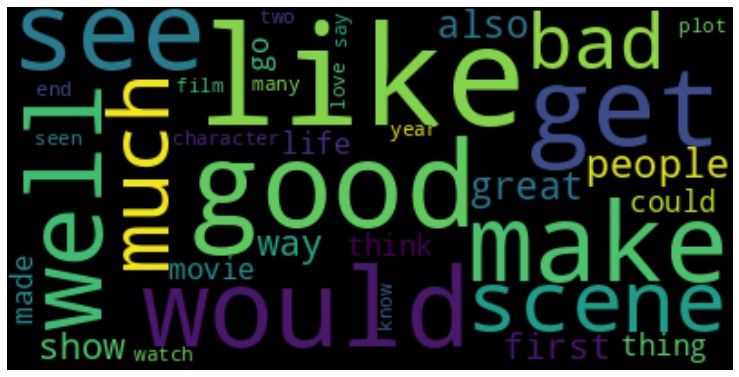

In [6]:
topWord()

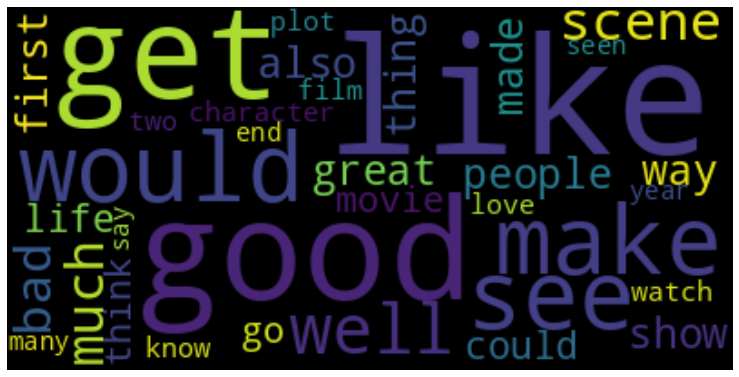

In [7]:
topWord("pos")

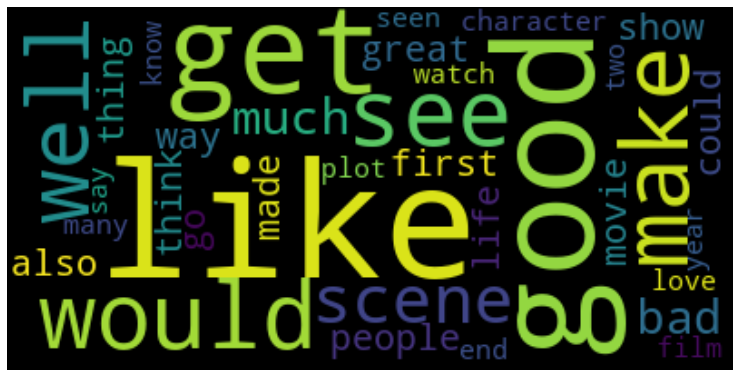

In [8]:
topWord("neg")

In [9]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(review["corpus"],review["label"],test_size=.2)

train = review.loc[review.type=="train"]
test = review.loc[review.type=="test"]
(train.shape,test.shape)

In [10]:
corpus_train = X_train.values

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(min_df=.01)
dtm = vec.fit_transform(corpus_train)
dtm.shape

(40000, 1630)

In [12]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import timeit

X_train,X_eval,Y_train,Y_eval = train_test_split(dtm,Y_train,test_size=.2)

xgb = XGBClassifier()
lgb = LGBMClassifier()
lr = LogisticRegression()
rf = RandomForestClassifier()
gbc = GradientBoostingClassifier()

models = {"xgb" : xgb,"lgb" : lgb,"lr" : lr,"rf" : rf ,"gbc" : gbc}

def fit_predict(estimator):
    t = timeit.timeit(lambda : estimator.fit(X_train,Y_train),number=1)
    acc_eval = accuracy_score(Y_eval,estimator.predict(X_eval))
    acc_train = accuracy_score(Y_train,estimator.predict(X_train))
    return (t,acc_train,acc_eval)

acc_train = []
acc_eval = []
time_fit = []
for m in models:
    t,train,eva =  fit_predict(models[m])
    acc_train.append(train)
    acc_eval.append(eva)
    time_fit.append(t)

/home/fredo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:51:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [13]:
leaderboard = pd.DataFrame([[list(models)[i],acc_train[i],acc_eval[i],time_fit[i]] for i in range(len(models))],\
                           columns=["model","acc_train","acc_eval","time"])
leaderboard

,model,acc_train,acc_eval,time
0,xgb,0.940094,0.845875,42.168797
1,lgb,0.901344,0.853500,11.319796
2,lr,0.894500,0.873250,0.382512
3,rf,1.000000,0.839500,81.167647
4,gbc,0.823656,0.810250,63.389850


In [14]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(random_state=42)

params_lr = {'tol': [0.0001, 0.001, 0.00001], 
             'C': [0.01,0.1,0.5,1.0,2,5], 
             'solver' : ['sag', 'saga'], 
             'max_iter': [50, 100, 150,175,200,225,250]}

grid = GridSearchCV(lr, params_lr, scoring='accuracy').fit(X_train,Y_train)

grid.best_params_

{'C': 1.0, 'max_iter': 50, 'solver': 'saga', 'tol': 0.001}

In [15]:
grid.best_score_

0.8760937500000001

In [16]:
models["lr"].get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [17]:
lr_best = LogisticRegression(C=1,solver="sag",tol=0.001,max_iter=50).fit(X_train,Y_train)

In [18]:
corpus_test = X_test.values

dtm_test = vec.transform(corpus_test)

pred_lr = lr_best.predict(dtm_test)

accuracy_score(Y_test,pred_lr)

0.8713

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(Y_test,pred_lr)

array([[4380,  703],
       [ 584, 4333]])

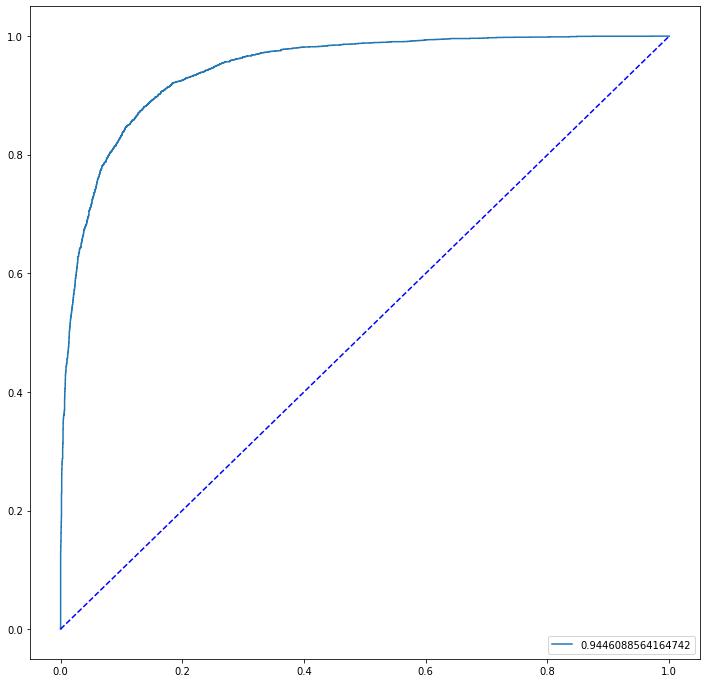

In [20]:
from sklearn.metrics import auc,roc_curve

FP,TP,s = roc_curve(Y_test,lr_best.predict_proba(dtm_test)[:,1])
plt.figure(figsize=(12,12))
plt.plot(FP,TP,label=str(auc(FP,TP)))
plt.plot([0,1],[0,1],color="blue",linestyle="--")
plt.legend(loc=4)